In [1]:
import numpy as np
from dtw import dtw

import matplotlib.pyplot as plt

In [2]:
x = np.array([6, 0, 1, 0, 6, 1, 2]).reshape(-1, 1)
y = np.array([1, 2, 0, 2, 1, 2, 2, 4]).reshape(-1, 1)

Дистанция между векторами: 13.0
[[ 5.  9. 15. 19. 24. 28. 32. 34.]
 [ 6.  7.  7.  9. 10. 12. 14. 18.]
 [ 6.  7.  8.  8.  8.  9. 10. 13.]
 [ 7.  8.  7.  9.  9. 10. 11. 14.]
 [12. 11. 13. 11. 14. 13. 14. 13.]
 [12. 12. 12. 12. 11. 12. 13. 16.]
 [13. 12. 14. 12. 12. 11. 11. 13.]]


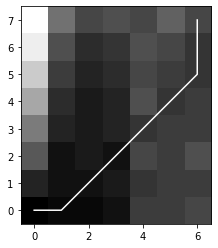

In [3]:
manhattan_distance = lambda x, y: np.abs(x - y)

d, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=manhattan_distance)

print(f'Дистанция между векторами: {d}')

print(acc_cost_matrix)

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()